In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [2]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
#%% obs grid
Nx, Ny = 30, 30
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 3
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [6]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

### S matrix

In [7]:
super_to_obs_1d = lambda Zsuper1d: super_to_obs(Zsuper1d.reshape(M,N)).ravel()
super_to_obs_vmap = jit(vmap(super_to_obs_1d, (0), 1))
Zsupeye = np.eye(M*N)
Smat = super_to_obs_vmap(Zsupeye)

In [8]:
truepsffunc = gaussian_psf

In [9]:
Nsource = 10*2
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx
ycenters = np.random.rand(Nsource)*Ny
truepsfkws = {"sigma": 1}

In [10]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [11]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

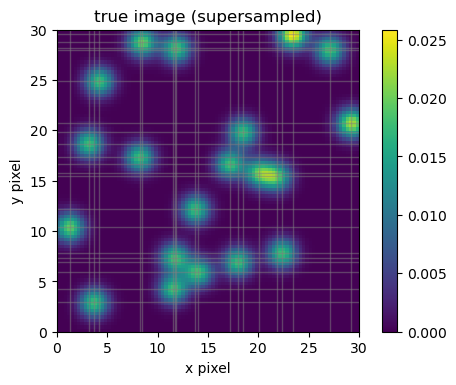

In [12]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

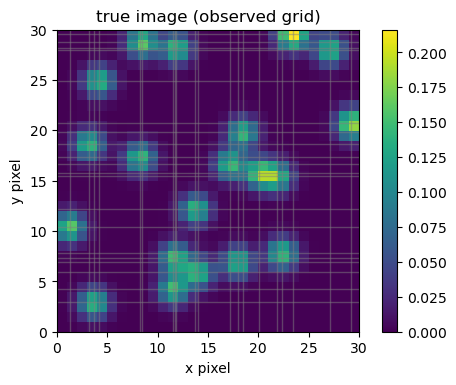

In [13]:
Z = super_to_obs(Zs)
Z_using_mat = jnp.dot(Smat,Zs.ravel()).reshape(Nx,Ny)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [14]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

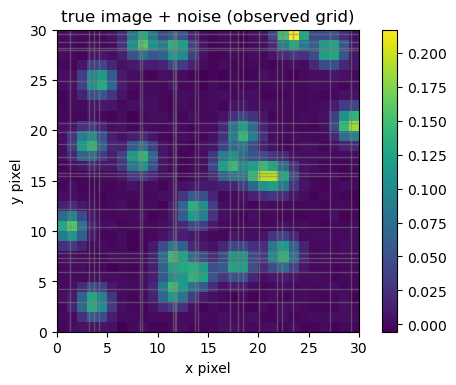

In [15]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [16]:
# define supersampled ePSF
#xext, yext = 10., 10.
#dx, dy = 1., 1.
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)
gpsfvalues1d = vmap(gpsf.psfvalues1d, (None,None,None,None,0), 1)

PSF grid shape: (21, 21)


In [17]:
trans_matrix = vmap(gpsfvalues1d, (None,None,0,0,None), 0)
paramseye = np.eye(gpsf.Nparams)

In [18]:
f_mean = 1./(gpsf.Nparams*gpsf.ds)

In [19]:
parr = jnp.ones(gpsf.Nparams) * f_mean

In [20]:
jnp.sum(trans_matrix(spix.X, spix.Y, xcenters, ycenters, paramseye)@parr, axis=1)*spix.ds

DeviceArray([0.95456388, 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 0.76327518, 0.67623377, 0.56672084,
             1.        , 0.91605392, 1.        , 0.60719275, 1.        ,
             1.        , 0.68029391, 1.        , 1.        , 0.71924784],            dtype=float64)

In [21]:
def gpkernel(gpsf, lenx, leny, lna):
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    cov = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    return cov

In [22]:
Ns = Nsource
def params_to_dict(params):
    dic = {}
    c = params[:Ns]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dic['c'] = np.array(c)[1:]
    dic['x'] = np.array(xc)[1:]
    dic['y'] = np.array(yc)[1:]
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

In [23]:
def gpsfloglike(params, Z, sigmaerr, gpsf):

    carr = jnp.r_[1., params[1:Ns]]
    xarr = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yarr = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)
    
    return mv.log_prob(Z.ravel())

objective = lambda p: -gpsfloglike(p, Zobs, sigmaerr, gpsf)

In [24]:
def loglikelihood(params, Z1d, sigmaerr):
    #c = params[:Ns]
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    #lnlenx, lnleny, lna = 1., 1., -3.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)

    Amat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    #Amat = jnp.sum(Amat, axis=0)
    Amat = jnp.dot(Smat, jnp.sum(Amat, axis=0))

    cov = jnp.dot(Amat, jnp.dot(kernel, Amat.T))
    cov += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    
    SinvZ = jnp.linalg.solve(cov, Z1d)

    #return -0.5 * len(Z1d) * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)
    return -0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ) - 0.5 * len(Z1d) * jnp.log(2*jnp.pi)

#objective = lambda p: -loglikelihood(p, Zobs.ravel(), sigmaerr)

In [25]:
width = 2.
shift = 0.
params = np.array([1.]*Ns + list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0, 0, -5])
params_lower = [0]*Ns + list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-5+3, -5+3, -10.]
params_upper = [10]*Ns + list(xcenters[1:]+width) + list(ycenters[1:]+width) + [2., 2., 0.]
bounds = (params_lower, params_upper)

In [26]:
import jaxopt
method = "TNC"
#method = "Nelder-Mead"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)#, options={'gtol': 1e-100, 'maxfun': 10000})

In [29]:
%time loglikelihood(params, Zobs.ravel(), sigmaerr)

CPU times: user 37.9 ms, sys: 3.06 ms, total: 41 ms
Wall time: 25.6 ms


DeviceArray(33.00384964, dtype=float64)

In [30]:
%time gpsfloglike(params, Zobs, sigmaerr, gpsf)

CPU times: user 31.8 ms, sys: 2.1 ms, total: 33.9 ms
Wall time: 19.7 ms


DeviceArray(33.00384964, dtype=float64)

In [31]:
def show_res(res):
    print ()
    print (res)
    popt, state = res
    pdict = params_to_dict(popt)
    xmean = pdict['x']
    ymean = pdict['y']
    dx = xmean - xcenters[1:]
    dy = ymean - ycenters[1:]
    print ("# dx = %.3f +/- %.3f"%(np.mean(dx),np.std(dx)))
    print ("# dy = %.3f +/- %.3f"%(np.mean(dy),np.std(dy)))
    return popt, pdict

In [32]:
%%time
res = solver.run(params, bounds=bounds)
popt, pdict = show_res(res)


OptStep(params=DeviceArray([ 1.        ,  0.99705979,  0.99646071,  0.98509137,
              0.97819597,  1.00387094,  1.03265963,  1.01023966,
              1.10913083,  1.46653178,  0.98547642,  1.00109839,
              0.9936165 ,  1.29466149,  0.99836367,  0.98260489,
              1.10586422,  0.97570872,  0.99122444,  1.03139831,
             22.35824598, 17.15103286, 13.72649885, 11.53434934,
              8.20627569, 20.04946912, 11.83657456,  8.45055005,
             23.39092095, 17.97171826,  3.69766735, 11.67780889,
             29.27081488, 14.00718883,  4.2109357 ,  1.25391281,
             21.86569596, 18.4799653 , 27.07070716,  7.78308421,
             16.6609535 , 12.14141112,  4.23881475, 17.30468195,
             15.77182219, 28.14918386, 28.77850948, 29.54643697,
              6.91563486,  2.92220752,  7.36438046, 20.70756984,
              5.89433696, 24.88053601, 10.39029475, 15.42058134,
             19.81800896, 27.9968426 ,  0.25102973,  0.31222459,
         

In [33]:
xmean = pdict['x']#[1:]
ymean = pdict['y']#[1:]
xstd, ystd = 0*xmean, 0*ymean
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
print (np.mean(xmean-xcenters[1:]), np.mean(ymean-ycenters[1:]))

-0.0032884602034245073 -0.008596941305846194


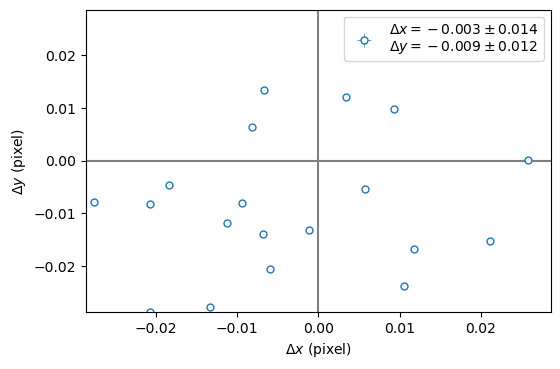

In [34]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))

In [115]:
def prediction(params, Z1d, sigmaerr, return_matrices=False):
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    
    Sf = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    Tmat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    U = jnp.dot(Smat, jnp.sum(Tmat, axis=0))
    Sd = sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    Pd = jnp.eye(pix.Nx*pix.Ny) / sigmaerr**2
    if return_matrices:
        return Sf, Sd, U, Pd
    
    # for ePSF
    Sigma_pred = Sf - Sf@U.T@jnp.linalg.inv(Sd+U@Sf@U.T)@U@Sf
    mu_pred = Sigma_pred@U.T@Pd@Z1d
    
    # for image
    #Sigma_pred = Sd - Sd@U@(Sf - Sf@U.T@jnp.linalg.inv(Pd + U@Sf@U.T)@U@Sf)@U.T@Sd
    #mu_pred = Sigma_pred@Pd@Z1d

    return mu_pred, Sigma_pred, U

In [116]:
mu_pred, Sigma_pred, U = prediction(popt, Zobs.ravel(), sigmaerr)

In [138]:
meanpsf = mu_pred.reshape(gpsf.Nx,gpsf.Ny)
meanpsf /= jnp.sum(meanpsf*gpsf.ds)
Xg, Yg = np.meshgrid(gpsf.xgrid_center, gpsf.ygrid_center)
truepsf = truepsffunc(Xg, Yg, 0, 0, **truepsfkws)
truepsf /= jnp.sum(truepsf*gpsf.ds)

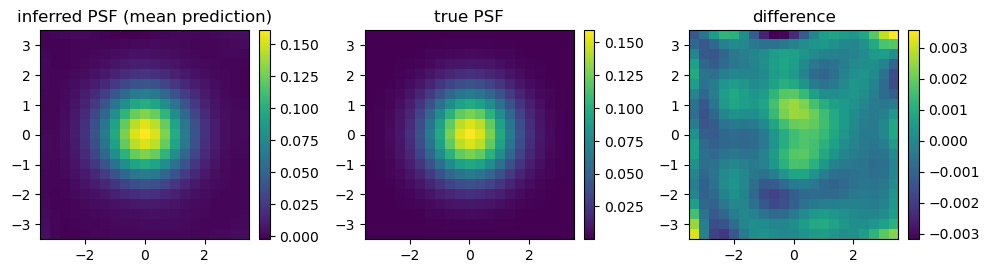

In [139]:
fig, ax = plt.subplots(1,3,figsize=(10,10))
for i,(image,title) in enumerate(zip([meanpsf, truepsf, meanpsf-truepsf], ['inferred PSF (mean prediction)', 'true PSF', 'difference'])):
    im = ax[i].imshow(image, origin='lower', extent=[gpsf.xgrid_edge[0], gpsf.xgrid_edge[-1], gpsf.ygrid_edge[0], gpsf.ygrid_edge[-1]])
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    ax[i].set_title(title)
fig.tight_layout()

/tmp/ipykernel_32043/3336029868.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(ylim)


Text(0.5, 0, 'error normalized residual')

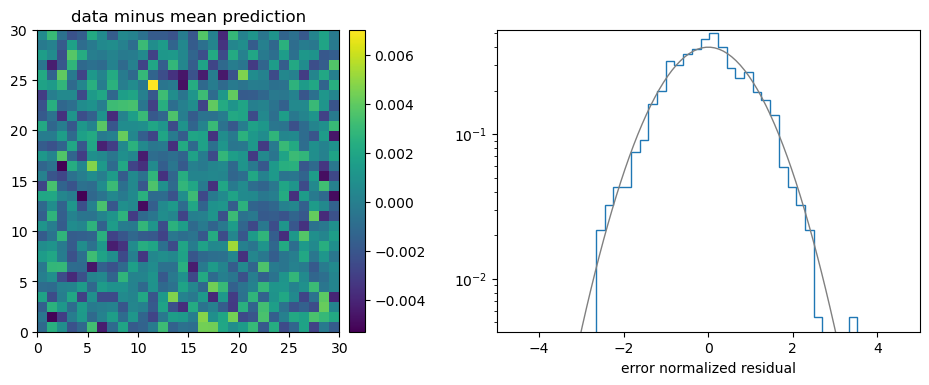

In [186]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
im = ax[0].imshow(Zobs-(U@mu_pred).reshape(pix.Nx,pix.Ny), origin='lower', 
                  extent=[pix.xgrid_edge[0], pix.xgrid_edge[-1], pix.ygrid_edge[0], pix.ygrid_edge[-1]])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax[0].set_title('data minus mean prediction')
ax[1].hist(np.array(Zobs.ravel()-(U@mu_pred))/sigmaerr, histtype='step', lw=1, bins=30, density=True)
ylim = ax[1].get_ylim()
ax[1].set_yscale("log")
ax[1].set_xlim(-5,5)
ax[1].set_ylim(ylim)
x0 = np.linspace(-5, 5, 100)
ax[1].plot(x0, np.exp(-0.5*x0**2)/np.sqrt(2*np.pi), color='gray', lw=1)
ax[1].set_xlabel("error normalized residual")

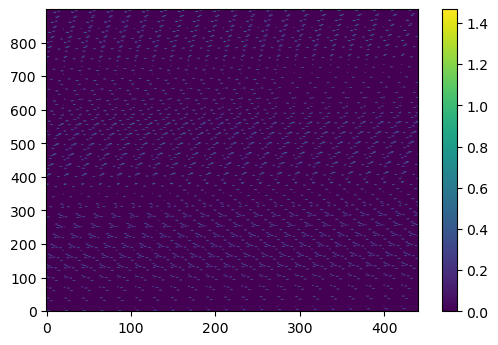

In [191]:
# U is sparse
plt.imshow(U, aspect='auto', origin='lower')
plt.colorbar()

In [46]:
from tinygp import kernels, GaussianProcess
width = 2.
shift = 0.
def gpsfmodel(Z, sigmaerr, gpsf, xcenters, ycenters):
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=2)) # fail for lnlenx > 0? -> only fcov
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=2))
    lna = numpyro.sample("lna", dist.Uniform(low=-10, high=0))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    #mv = dist.MultivariateNormal(loc=0., covariance_matrix=fcov)
    #numpyro.sample("psfvals1d", mv)
    
    ones = jnp.ones_like(xcenters) 
    c = numpyro.sample("c", dist.TruncatedNormal(loc=ones[1:], scale=ones[1:], low=ones[1:]*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-width, high=xcenters[1:]+width))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-width, high=ycenters[1:]+width))
    
    carr = jnp.r_[1., c]
    xarr = jnp.r_[xcenters[0]+shift, x]
    yarr = jnp.r_[ycenters[0]+shift, y] 
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)

    numpyro.factor("loglike", mv.log_prob(Z.ravel()))
    #numpyro.sample("im1d", mv)
    #numpyro.sample("obs", mv, obs=Z.ravel())

In [47]:
from numpyro.infer import init_to_value
init_strategy = init_to_value(values=pdict)

In [48]:
kernel = numpyro.infer.NUTS(gpsfmodel, target_accept_prob=0.90, init_strategy=init_strategy)

In [49]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
rng_key = random.PRNGKey(0)

In [50]:
mcmc.run(rng_key, Zobs, sigmaerr, gpsf, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [12:14<00:00,  1.36it/s, 15 steps of size 1.64e-01. acc. prob=0.94]


In [51]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      c[0]      1.00      0.01      1.00      0.98      1.02     75.11      1.04
      c[1]      1.00      0.01      1.00      0.98      1.02     73.99      1.04
      c[2]      0.99      0.01      0.99      0.97      1.00    100.29      1.03
      c[3]      0.98      0.01      0.98      0.96      1.00     93.26      1.04
      c[4]      1.01      0.01      1.01      0.99      1.02     91.54      1.04
      c[5]      1.03      0.02      1.03      1.00      1.06     51.05      1.00
      c[6]      1.01      0.01      1.01      1.00      1.03     68.08      1.05
      c[7]      1.11      0.01      1.11      1.10      1.13     81.75      1.04
      c[8]      1.47      0.02      1.47      1.44      1.49     78.79      1.02
      c[9]      0.99      0.01      0.99      0.97      1.00     77.34      1.04
     c[10]      1.00      0.01      1.00      0.98      1.02    104.15      1.03
     c[11]      1.00      0

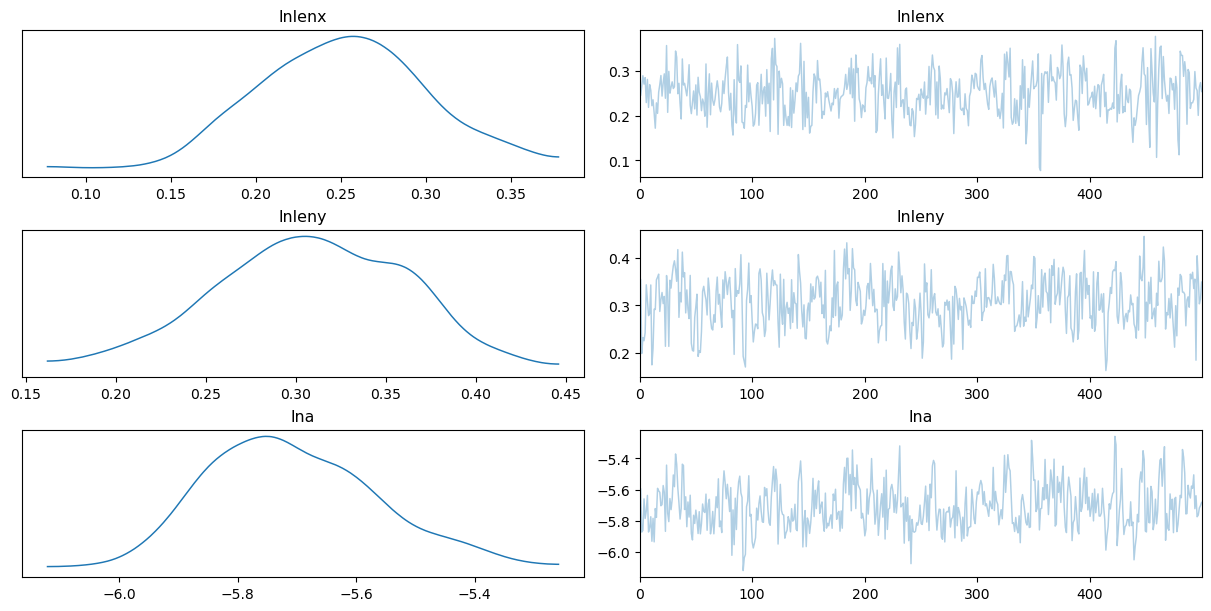

In [52]:
from numpyro.infer import Predictive
from arviz import plot_trace
fig = plot_trace(mcmc, var_names=['lnlenx', 'lnleny', 'lna'])

In [53]:
smp = mcmc.get_samples()

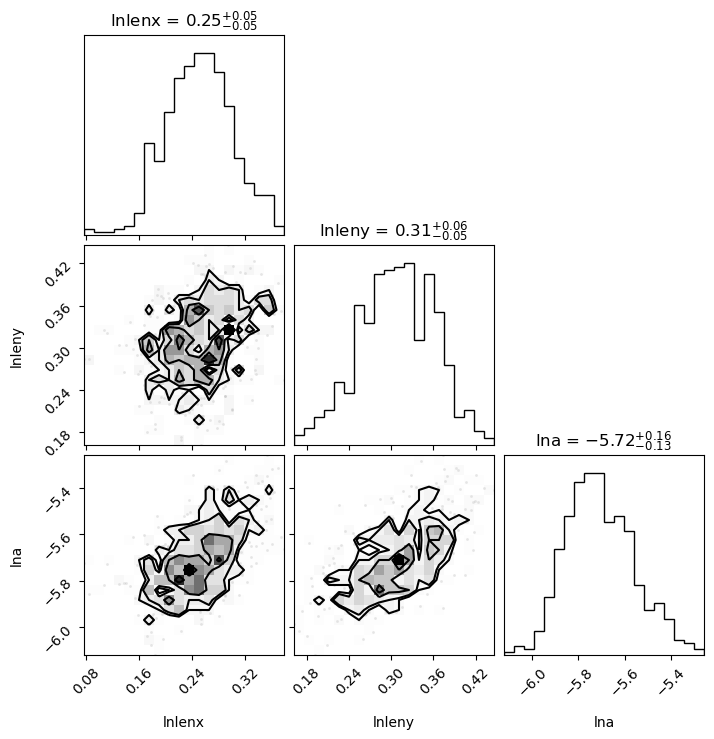

In [54]:
import pandas as pd
pnames = ["lnlenx", "lnleny", "lna"]
hyper = pd.DataFrame(data=dict(zip(pnames, [smp[k] for k in pnames])))
fig = corner.corner(hyper, labels=pnames, show_titles="%.2f")

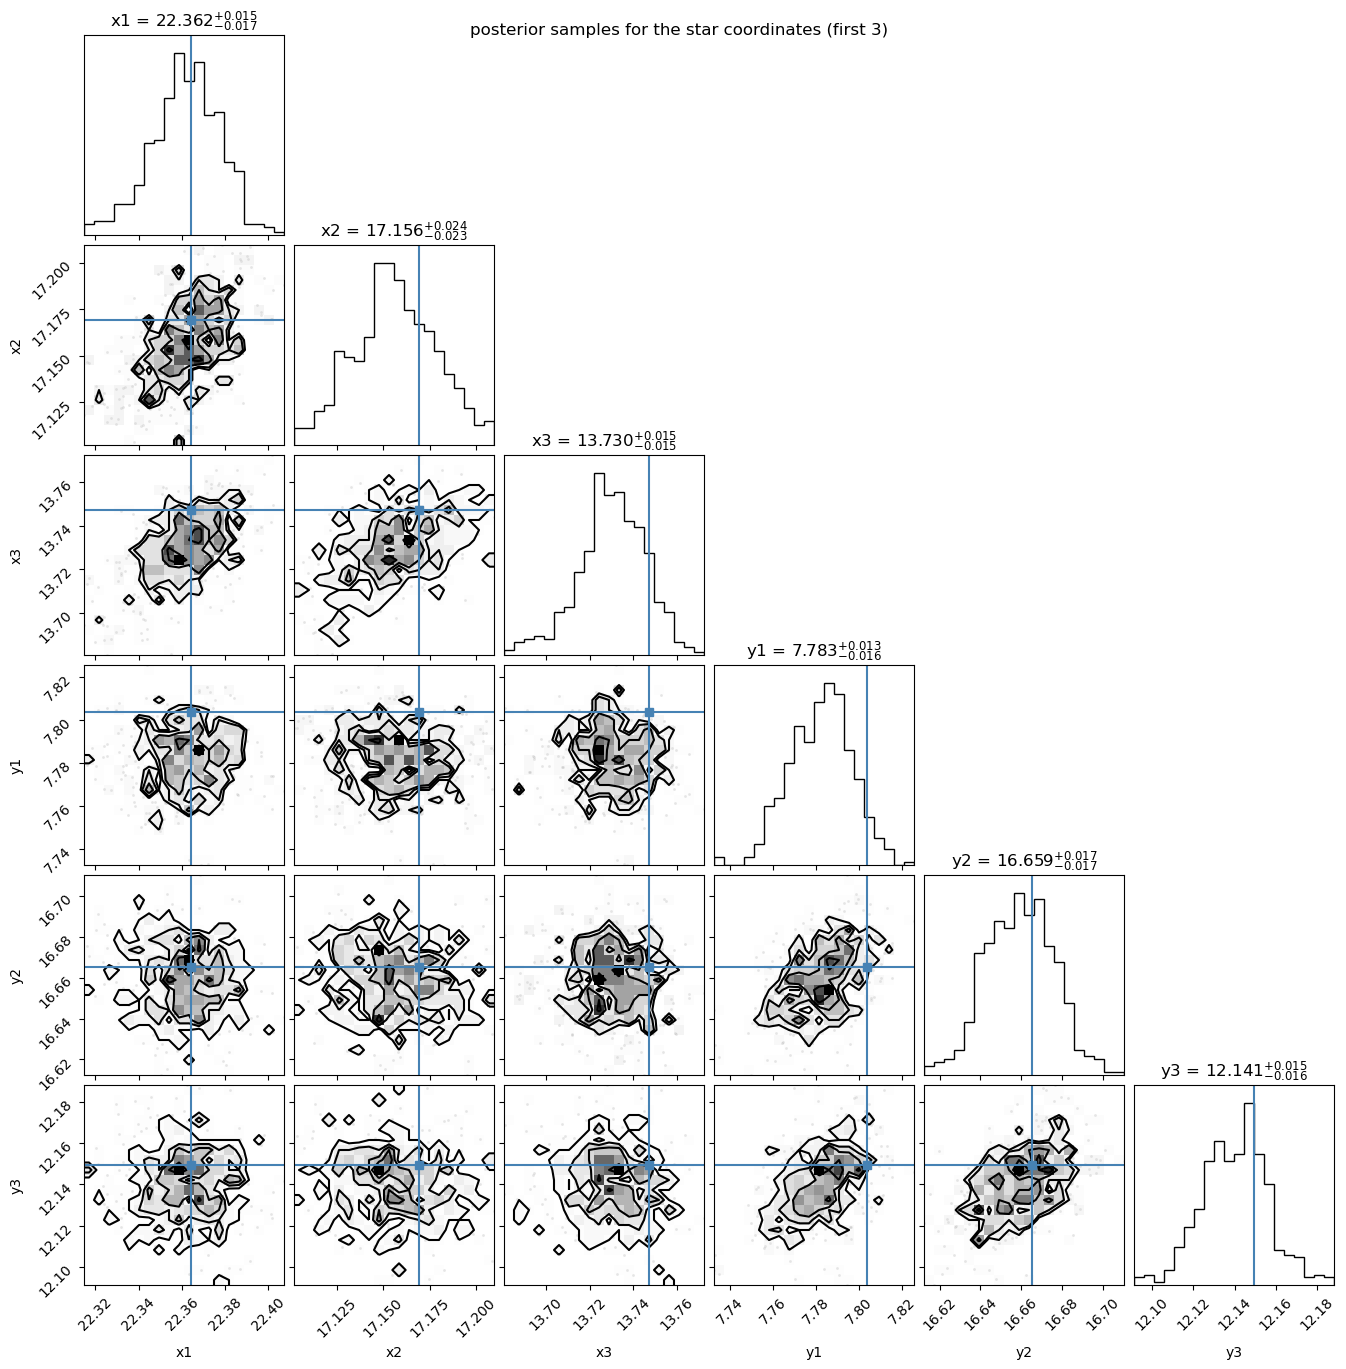

In [55]:
nplot = 3
fig = corner.corner(np.c_[np.array(smp['x'])[:,:nplot], np.array(smp['y'])[:,:nplot]], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:][:nplot]+shift, ycenters[1:][:nplot]+shift],
                   labels=["x%d"%i for i in range(1,nplot+1)]+["y%d"%i for i in range(1,nplot+1)])
fig.suptitle("posterior samples for the star coordinates (first %d)"%nplot);

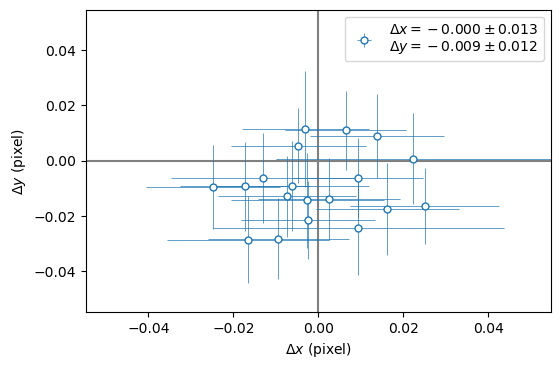

In [56]:
xmean, xstd = np.mean(smp['x'], axis=0), np.std(smp['x'], axis=0)
ymean, ystd = np.mean(smp['y'], axis=0), np.std(smp['y'], axis=0)
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))